# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

#[Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

### Import useful libraries

In [4]:
!pip install datasets

  Using cached datasets-3.1.0-py3-none-any.whl.metadata (20 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
Using cached datasets-3.1.0-py3-none-any.whl (480 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)
Using cached xxhash-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following de

In [5]:
import os
import requests
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import zipfile
import numpy as np
from tqdm import tqdm
import random
import copy
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay, classification_report
from IPython.display import display, HTML
from wordcloud import WordCloud
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request
from datasets import Dataset
from transformers import TrainingArguments
from transformers import DataCollatorWithPadding
from transformers import Trainer

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

### Create train, validation and test DataFrames
 * Download json files *test.json*, *training.json* and *validation.json* from [here](https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/).
 * Load the json files into pandas DataFrames

In [6]:
base_url = "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/"
json_files = ["test.json", "training.json", "validation.json"]
local_dir = Path("Assignment%201/data")
local_dir.mkdir(parents=True, exist_ok=True)

# Download each file
for file_name in json_files:
    url = base_url + file_name
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_dir / file_name, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")
    else:
        print(f"Failed to download {file_name}")

# Load JSON files into pandas DataFrames
dataframes = {}
for file_name in json_files:
    with open(local_dir / file_name, "r") as file:
        data = json.load(file)
        dataframes[file_name] = pd.DataFrame(data)

original_train_df = dataframes['training.json']
original_validation_df = dataframes['validation.json']
original_test_df = dataframes['test.json']

Downloaded test.json
Downloaded training.json
Downloaded validation.json


### Transform the DataFrames as requested

In [7]:
def determine_majority(response_list):
    yes_count = response_list.count("YES")
    no_count = response_list.count("NO")
    if yes_count > no_count:
        return 1
    elif no_count > yes_count:
        return 0
    else:
        return 2

def transform_df(df):
    df = df.T
    df['hard_label_task1'] = df['labels_task1'].apply(determine_majority)
    df = df[df['lang'] == 'en']
    df = df[df['hard_label_task1'] != 2]
    df = df[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]

    return df

In [8]:
original_train_df = transform_df(original_train_df)
original_validation_df = transform_df(original_validation_df)
original_test_df = transform_df(original_test_df)
original_train_df

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0
...,...,...,...,...
203256,203256,en,idk why y’all bitches think having half your a...,1
203257,203257,en,This has been a part of an experiment with @Wo...,1
203258,203258,en,"""Take me already"" ""Not yet. You gotta be ready...",1
203259,203259,en,@clintneedcoffee why do you look like a whore?...,1


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [9]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

In [10]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Perform Data Cleaning
 * Remove emojis
 * Remove hashtags
 * Remove mentions
 * Remove URLs
 * Remove special characters and symbols
 * Remove specific quote characters
 * Convert to lowercase
 * Tokenize the tweet
 * Remove stopwords
 * Lemmatize the word


In [11]:
lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
    tweet = re.sub(r'#\w+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'http\S+|www\S+', '', tweet)
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    tweet = tweet.replace('“', '').replace('”', '').replace('‘', '').replace('’', '')
    tweet = tweet.lower()
    words = word_tokenize(tweet)
    stop_words = set(stopwords.words('english'))
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    cleaned_tweet = ' '.join(words)

    return cleaned_tweet

train_df['tweet'] = train_df['tweet'].apply(clean_tweet)
validation_df['tweet'] = validation_df['tweet'].apply(clean_tweet)
test_df['tweet'] = test_df['tweet'].apply(clean_tweet)

In [12]:
train_df.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,writing uni essay local pub coffee random old ...,1
200003,200003,en,2021 1921 dont appreciate two ride team member...,1
200006,200006,en,according customer plenty time go spent stirli...,1
200007,200007,en,bloke drink beer sorry arent bloke drink wine ...,1
200008,200008,en,new shelf week looking forward reading book,0


# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

### Download and extract GloVe embeddings with dimension of 100.

In [13]:
def download_glove_embeddings(glove_url, save_path='glove.zip', extract_path='glove'):
    if not os.path.exists(extract_path):
        print("Downloading GloVe embeddings...")

        # download with a progress bar
        response = requests.get(glove_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(save_path, 'wb') as f, tqdm(
            desc="Downloading",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                f.write(data)
                bar.update(len(data))

        print("Extracting GloVe embeddings...")
        with zipfile.ZipFile(save_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

        # Remove the zip file
        os.remove(save_path)
        print("Download and extraction complete.")
    else:
        print("GloVe embeddings already downloaded.")


# Load the GloVe embeddings
def load_glove_embeddings(filepath, embedding_dim=100):
    embeddings = {}
    with open(filepath, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
download_path = 'glove.6B.zip'
extract_path = 'glove'

# download and extract GloVe embeddings
download_glove_embeddings(glove_url, download_path, extract_path)

# embedding dimension
embedding_dim = 100
glove_filepath = os.path.join(extract_path, f'glove.6B.{embedding_dim}d.txt')

glove_embeddings = load_glove_embeddings(glove_filepath, embedding_dim)
print("Loaded GloVe embeddings with dimension:", embedding_dim)

Downloading: 100%|██████████| 822M/822M [02:38<00:00, 5.44MB/s]


Extracting GloVe embeddings...
Download and extraction complete.
Loaded GloVe embeddings with dimension: 100


### Pad the tweets to have them of the same lenght.

In [14]:
def find_series_max_len(series_list):
    all_text = pd.concat(series_list, ignore_index=True)
    word_count = all_text.apply(lambda x: len(str(x).split()))
    max_word_count = word_count.max()
    return max_word_count

def pad_text_column(df, column_name, max_len, pad_token="<PAD>"):
    df['padded_' + column_name] = df[column_name].apply(lambda x: x if isinstance(x, list) else x.split())  # Tokenize if not already
    df['padded_' + column_name] = df['padded_' + column_name].apply(
        lambda x: x[:max_len] + [pad_token] * (max_len - len(x)) if len(x) < max_len else x[:max_len]
    )
    return df

# find the maximum lenght of a tweet
MAX_LEN = find_series_max_len([train_df['tweet'], validation_df['tweet'], test_df['tweet']])
print(f"Max lenght found: {MAX_LEN}")

# pad the tweets
train_df = pad_text_column(train_df, 'tweet', MAX_LEN)
validation_df = pad_text_column(validation_df, 'tweet', MAX_LEN)
test_df = pad_text_column(test_df, 'tweet', MAX_LEN)

print(train_df['padded_tweet'].iloc[0])

Max lenght found: 36
['writing', 'uni', 'essay', 'local', 'pub', 'coffee', 'random', 'old', 'man', 'keep', 'asking', 'drunk', 'question', 'im', 'trying', 'concentrate', 'amp', 'end', 'good', 'luck', 'youll', 'end', 'getting', 'married', 'use', 'anyway', 'alive', 'well', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


### Build the vocabulary and the embeddings on the train set.

In [15]:
# Tokenize tweets and build vocabulary
def build_vocab_and_embeddings(data, embeddings_index, embedding_dim):
    vocab = {}
    word_embeddings = []
    for tweet in data['padded_tweet']:
        for token in tweet:
            if token not in vocab:
                if token in embeddings_index:
                    # Use GloVe embedding
                    vocab[token] = len(vocab)
                    word_embeddings.append(embeddings_index[token])
                else:
                    # Generate a random embedding for OOV tokens in the training set
                    vocab[token] = len(vocab)
                    word_embeddings.append(np.random.uniform(-0.1, 0.1, embedding_dim))
    return vocab, word_embeddings

# Build vocabulary and embeddings for the training set
vocab, word_embeddings = build_vocab_and_embeddings(train_df, glove_embeddings, embedding_dim)

### Set the embedding for the Unknown words.

In [16]:
unk_token = '[UNK]'
vocab[unk_token] = len(vocab)

# embedding for '[UNK]': mean of GloVe embeddings
unk_embedding = np.mean(word_embeddings, axis=0)
word_embeddings = np.vstack([word_embeddings, unk_embedding])

### Embed train, validation and test sets.

In [17]:
def embed_tweet(df, vocab, word_embeddings):
    data = df.copy()
    new_tweet = []
    for tweet in data['padded_tweet']:
        embedded_tweet = []
        for token in tweet:
            if token not in vocab:
                # token is OOV so considered UNK
                embedded_tweet.append(word_embeddings[vocab['[UNK]']])
            else:
                embedded_tweet.append(word_embeddings[vocab[token]])
        new_tweet.append(embedded_tweet)
    data['padded_tweet'] = new_tweet
    return data

# Embed all the df with our extended GloVe embeddings
train_df_embedded = embed_tweet(train_df, vocab, word_embeddings)
validation_df_embedded = embed_tweet(validation_df, vocab, word_embeddings)
test_df_embedded = embed_tweet(test_df, vocab, word_embeddings)
train_df_embedded.head()

,id_EXIST,lang,tweet,hard_label_task1,padded_tweet
200002,200002,en,writing uni essay local pub coffee random old ...,1,"[[0.17459000647068024, 0.2806999981403351, -0...."
200003,200003,en,2021 1921 dont appreciate two ride team member...,1,"[[0.4375700056552887, 0.5958300232887268, 0.52..."
200006,200006,en,according customer plenty time go spent stirli...,1,"[[-0.06825800240039825, -0.04764899984002113, ..."
200007,200007,en,bloke drink beer sorry arent bloke drink wine ...,1,"[[0.1125900000333786, 0.4171999990940094, 0.62..."
200008,200008,en,new shelf week looking forward reading book,0,"[[-0.04395899921655655, 0.18935999274253845, 0..."


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

### Bidirectional LSTM with a Dense layer on top.
In the code: lstm_out has shape `[batch, seq_len, hidden_size * 2]`.<br>
Being bidirectional, the hidden state is the concatenation of the last forward and backward hidden states.

In [18]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=True):
        super(BiLSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
        # for bidirectional: lstm_out has shape [batch, seq_len, hidden_size * 2]
        lstm_out, (hidden, cell) = self.lstm(x)

        if self.lstm.bidirectional:
            # concatenate the last forward and backward hidden states
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        out = self.fc(hidden)
        return out.view(-1)

### Initialize the baseline model

In [19]:
input_size = 100
hidden_size = 128
num_layers = 1
output_size = 1

baseline_model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)

### Initialize Model 1
Being the baseline model with an additional LSTM layer, we have to specify only that `num_layers` has to be 2.



In [20]:
num_layers = 2

model_1 = BiLSTMModel(input_size, hidden_size, num_layers, output_size)

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

### Definition of a `CustomTrainer`
The trainer trains the given model on the different seeds given in input and plots the learning curve across the seeds. <br>
The `get_error()` function creates a DataFrame with the errors done on the dataset given in input.

In [23]:
class CustomTrainer:
    def __init__(self, model, output_size=5, learning_rate=0.001, num_epochs=20, batch_size=32, seed=42):
        self.set_seed(seed)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}", end='\n\n')

        self.model = model.to(self.device)
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def set_seed(self, seed):
        """Set the seed for reproducibility."""

        random.seed(seed)
        np.random.seed(seed)
        # PyTorch CPU
        torch.manual_seed(seed)
        # PyTorch GPU (or GPUs)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        # disable the auto-tuner to avoid randomness
        torch.backends.cudnn.benchmark = False
        self.seed = seed


    def train(self, train_df):
        """Train the model on the training data."""

        self.x_train = torch.tensor(train_df['padded_tweet'], dtype=torch.float32).to(self.device)
        self.y_train = torch.tensor(train_df['hard_label_task1'], dtype=torch.float32).to(self.device)
        self.train_dataset = TensorDataset(self.x_train, self.y_train)
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

        losses = []
        for epoch in tqdm(range(self.num_epochs), desc=f'Training with seed {self.seed}'):
            self.model.train()
            running_loss = 0.0

            for batch_idx, (inputs, labels) in enumerate(self.train_loader):
                self.optimizer.zero_grad()

                # forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                # backward pass
                loss.backward()
                # optimization
                self.optimizer.step()

                running_loss += loss.item()

            avg_loss = running_loss / len(self.train_loader)
            losses.append(avg_loss)
        return losses

    def test(self, test_df):
        """Evaluate the model on the test data."""

        x_test = torch.tensor(test_df['padded_tweet'], dtype=torch.float32).to(self.device)
        y_test = torch.tensor(test_df['hard_label_task1'], dtype=torch.float32).to(self.device)
        test_dataset = TensorDataset(x_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        self.model.eval()

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = self.model(inputs)
                predicted = torch.round(torch.sigmoid(outputs))

                all_preds.append(predicted.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        # flatten the lists
        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        # calculate f1-score and accuracy
        f1 = f1_score(all_labels, all_preds, average='macro')
        accuracy = (all_preds == all_labels).mean()

        return accuracy, f1, all_preds, all_labels


    def train_and_evaluate_multiple_seeds(self, train_df, test_df, num_seeds=5):
        """Train and evaluate the model multiple times with different seeds."""
        all_losses = []
        all_accuracies = []

        untrained_model = copy.deepcopy(self.model.state_dict())

        print(f"### Start training and testing with {num_seeds} seeds ###")
        # loop through multiple seeds
        for seed in range(num_seeds):
            self.set_seed(seed)

            # train and evaluate the model
            epoch_losses = self.train(train_df)
            accuracy, f1, _, _ = self.test(test_df)

            self.model.load_state_dict(untrained_model)

            print(f"Accuracy on val: {accuracy:.4f}, f1-score on val: {f1:.4f}", end="\n\n")
            all_losses.append(epoch_losses)
            all_accuracies.append(accuracy)

        all_losses = np.array(all_losses)
        all_accuracies = np.array(all_accuracies)

        # plot the learning curves: max, min, avg loss across all seeds
        self.plot_learning_curve(all_losses, all_accuracies)


    def plot_learning_curve(self, all_losses, all_accuracies):
        """Plot the learning curve across all seeds."""
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(all_losses.mean(axis=0), label='Avg Loss', color='blue')
        plt.fill_between(range(len(all_losses[0])), all_losses.min(axis=0), all_losses.max(axis=0), color='blue', alpha=0.2)
        plt.title('Learning Curve (Loss)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def get_errors(self, test_df):
        """Create a DataFrame with the errors of the model on the given dataset."""

        x_test = torch.tensor(test_df['padded_tweet'], dtype=torch.float32).to(self.device)
        y_test = torch.tensor(test_df['hard_label_task1'], dtype=torch.float32).to(self.device)
        texts = test_df['tweet']

        test_dataset = TensorDataset(x_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        self.model.eval()

        all_preds = []
        all_labels = []
        error_texts = []
        error_labels = []

        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(test_loader):
                outputs = self.model(inputs)
                predicted = torch.round(torch.sigmoid(outputs))
                for i, (pred, label) in enumerate(zip(predicted.cpu().numpy(), labels.cpu().numpy())):
                    if not np.array_equal(pred, label):
                        error_texts.append(texts.iloc[idx * self.batch_size + i])
                        error_labels.append(label)

        errors_df = pd.DataFrame({
            'tweet': error_texts,
            'label': error_labels
            })

        return errors_df

### Train and evaluate the baseline model.

Using device: cuda

### Start training and testing with 3 seeds ###


Training with seed 0: 100%|██████████| 30/30 [00:10<00:00,  2.89it/s]


Accuracy on val: 0.7785, f1-score on val: 0.7671



Training with seed 1: 100%|██████████| 30/30 [00:07<00:00,  3.76it/s]


Accuracy on val: 0.7848, f1-score on val: 0.7716



Training with seed 2: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s]


Accuracy on val: 0.7848, f1-score on val: 0.7744



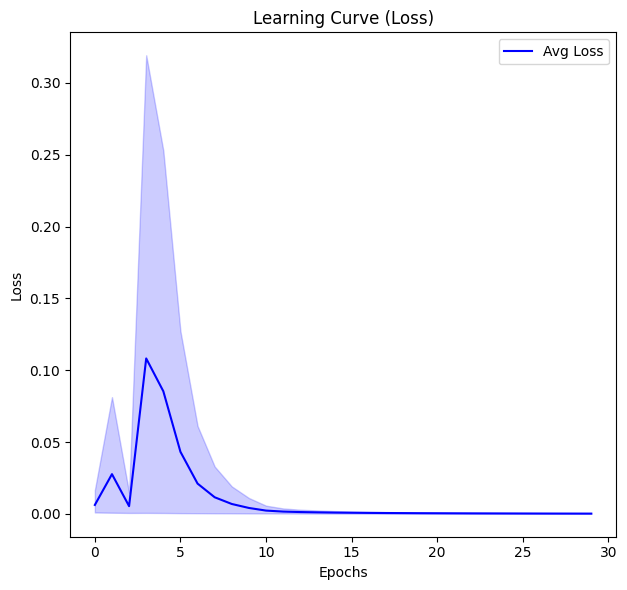



BASELINE MODEL:
Accuracy on test: 0.7098, f1-score on test: 0.7059



In [24]:
baseline_trainer = CustomTrainer(model=baseline_model, num_epochs=30, batch_size=32, learning_rate=0.001)

baseline_trainer.train_and_evaluate_multiple_seeds(train_df_embedded, validation_df_embedded, num_seeds=3)

baseline_accuracy, baseline_f1, baseline_preds, baseline_labels = baseline_trainer.test(test_df_embedded)
print('\n\nBASELINE MODEL:')
print(f"Accuracy on test: {baseline_accuracy:.4f}, f1-score on test: {baseline_f1:.4f}", end="\n\n")

### Get the error DataFrame for the baseline model.

In [25]:
baseline_error_df = baseline_trainer.get_errors(test_df_embedded)

### Train and evaluate Model 1.

Using device: cuda

### Start training and testing with 3 seeds ###


Training with seed 0: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


Accuracy on val: 0.8165, f1-score on val: 0.8058



Training with seed 1: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s]


Accuracy on val: 0.8481, f1-score on val: 0.8398



Training with seed 2: 100%|██████████| 30/30 [00:13<00:00,  2.25it/s]


Accuracy on val: 0.7658, f1-score on val: 0.7452



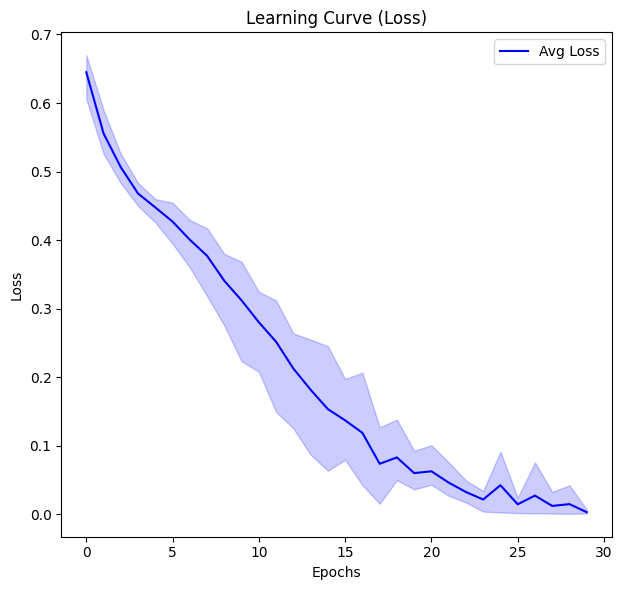


\MODEL 1:
Accuracy on test: 0.5594, f1-score on test: 0.3587



In [26]:
model_1_trainer = CustomTrainer(model=model_1, num_epochs=30, batch_size=32, learning_rate=0.001)

model_1_trainer.train_and_evaluate_multiple_seeds(train_df_embedded, validation_df_embedded, num_seeds=3)
model_1_accuracy, model_1_f1, model_1_preds, model_1_labels = model_1_trainer.test(test_df_embedded)
print('\n\MODEL 1:')
print(f"Accuracy on test: {model_1_accuracy:.4f}, f1-score on test: {model_1_f1:.4f}", end="\n\n")

### Get the error DataFrame for model 1.

In [27]:
model_1_error_df = model_1_trainer.get_errors(test_df_embedded)

# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [28]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

### Preprocess the tweets
Replace the usernames with *user* and the links with *http*

In [29]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

train_df['tweet'] = train_df['tweet'].apply(preprocess)
validation_df['tweet'] = validation_df['tweet'].apply(preprocess)
test_df['tweet'] = test_df['tweet'].apply(preprocess)
train_df.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@user it is 2021 not 1921. I dont appreciate t...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0


### Define the model and the tokenizer
Use the Twitter-roBERTa-base for Hate Speech Detection model as requested.

In [30]:
task='hate'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

transformer_model = AutoModelForSequenceClassification.from_pretrained(MODEL)
transformer_model.save_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

### Tokenize the tweets.

In [31]:
def preprocess_text(texts):
    return tokenizer(texts['tweet'], truncation=True)

train_data = Dataset.from_pandas(train_df)
validation_data = Dataset.from_pandas(validation_df)
test_data = Dataset.from_pandas(test_df)

train_data = train_data.map(preprocess_text, batched=True)
validation_data = validation_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)
train_data

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'hard_label_task1', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2870
})

In [32]:
train_data = train_data.rename_column('hard_label_task1', 'label')
validation_data = validation_data.rename_column('hard_label_task1', 'label')
test_data = test_data.rename_column('hard_label_task1', 'label')

In [33]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Define the traning arguments.

In [34]:
transformer_training_args = TrainingArguments(
    output_dir="test_dir",
    learning_rate=1e-6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none'
)

In [35]:
def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'acc': acc}

In [36]:
transformer_trainer = Trainer(
    model=transformer_model,
    args=transformer_training_args,
    train_dataset=train_data,
    eval_dataset=validation_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

### Train the transformer model.

In [37]:
transformer_trainer.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.445800,0.414833,0.835437,0.841772
2,0.413100,0.457808,0.842420,0.848101
3,0.435000,0.501009,0.855552,0.860759
4,0.422000,0.521328,0.861767,0.867089


TrainOutput(global_step=2872, training_loss=0.44071622545672656, metrics={'train_runtime': 404.1429, 'train_samples_per_second': 28.406, 'train_steps_per_second': 7.106, 'total_flos': 382640557810440.0, 'train_loss': 0.44071622545672656, 'epoch': 4.0})

### Compute f1-score and accuracy on the test set.

In [38]:
transformer_test_prediction_info = transformer_trainer.predict(test_data)
transformer_test_predictions, transformer_test_labels = transformer_test_prediction_info.predictions, transformer_test_prediction_info.label_ids

In [39]:
transformer_test_metrics = compute_metrics([transformer_test_predictions, transformer_test_labels])
transformer_f1 = transformer_test_metrics['f1']
transformer_accuracy = transformer_test_metrics['acc']
print(f"Accuracy on test: {transformer_accuracy:.4f}\nf1-score on test: {transformer_f1:.4f}", end="\n\n")

Accuracy on test: 0.8042
f1-score on test: 0.8026



# COSE DA FARE

 ### ERROR ANALYSIS
 FAQ: <br>
 Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

NOSTRE: <br>
 * Nelle frasi sbagliate, printare la frase con i token che non sono nel vocabolario colorati di rosso.
 * Controllo delle distribuzioni del dataset (bilanciato?)
 * Discutere gli errori comuni e le performance


 ### IDEE EXTRA
  * Usare embedding trainabili invece di globe
  * Mantenere le emojy e hashtag nel testo dei tweet
  * Usare tokenizer nel primo task


# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



#### Start with an analysis of the dataset to see the data

In [40]:
data_train = train_df
data_val = validation_df
data_test = test_df
data_train = data_train.rename(columns={'hard_label_task1': 'label'})
data_val = data_val.rename(columns={'hard_label_task1': 'label'})
data_test = data_test.rename(columns={'hard_label_task1': 'label'})

Plot the distribution of the labels in the train, validation and test sets.

Training Set
Label Distribution
label
0    1733
1    1137
Name: count, dtype: int64


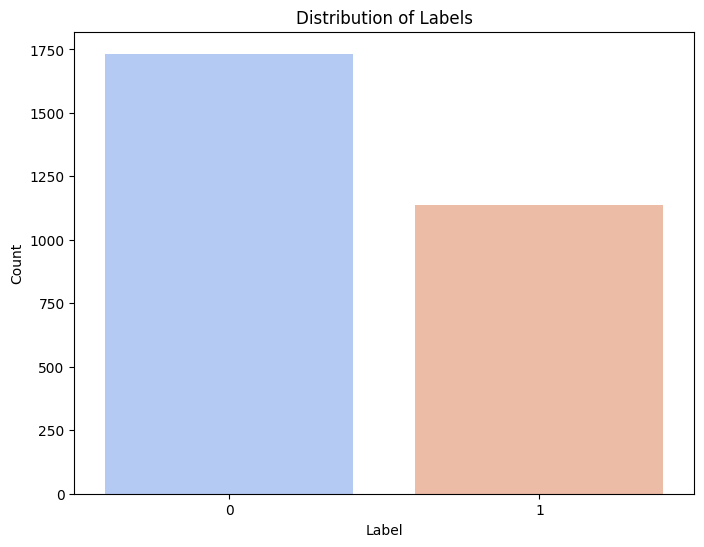




Validation Set
Label Distribution
label
0    90
1    68
Name: count, dtype: int64


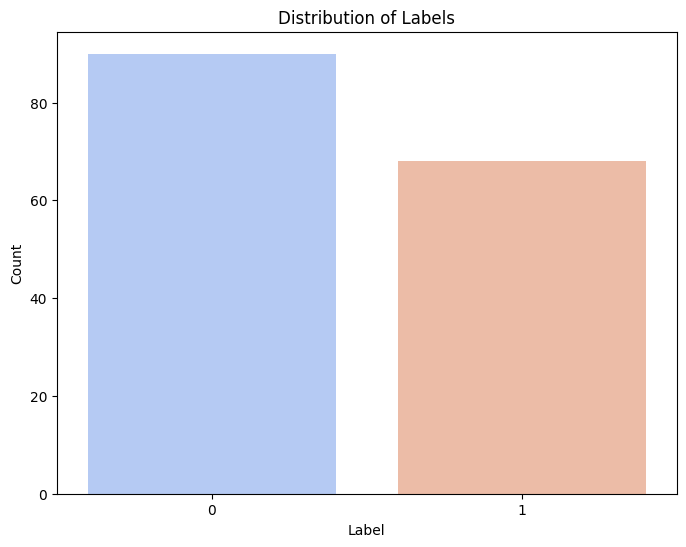




Test Set
Label Distribution
label
0    160
1    126
Name: count, dtype: int64


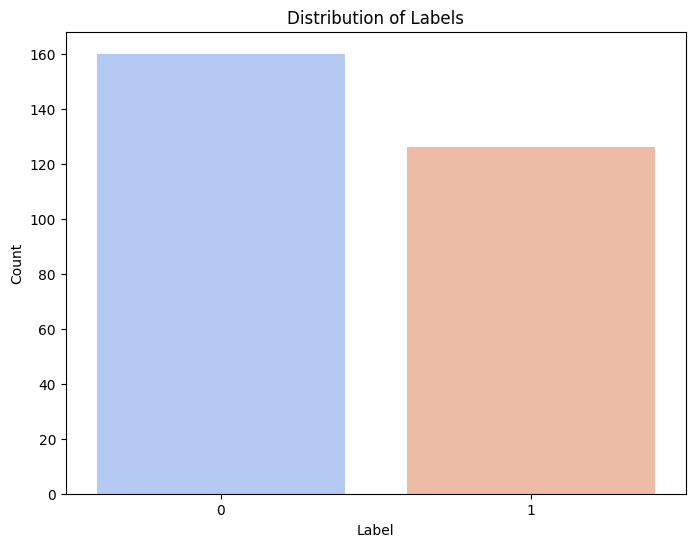

In [41]:
def plot_label_distribution(data_list, labels):
    for i in range(len(data_list)):
        data = data_list[i]
        print(labels[i])

        # Basic Statistics
        print("Label Distribution")
        print(data['label'].value_counts())

        # Label Distribution
        plt.figure(figsize=(8, 6))
        sns.countplot(data=data, x='label', palette='coolwarm')
        plt.title('Distribution of Labels')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.show()

        print('\n\n')

plot_label_distribution([data_train, data_val, data_test], labels=['Training Set', 'Validation Set', 'Test Set'])

Plot the train, validation and test set distribution of the tweet lenght.

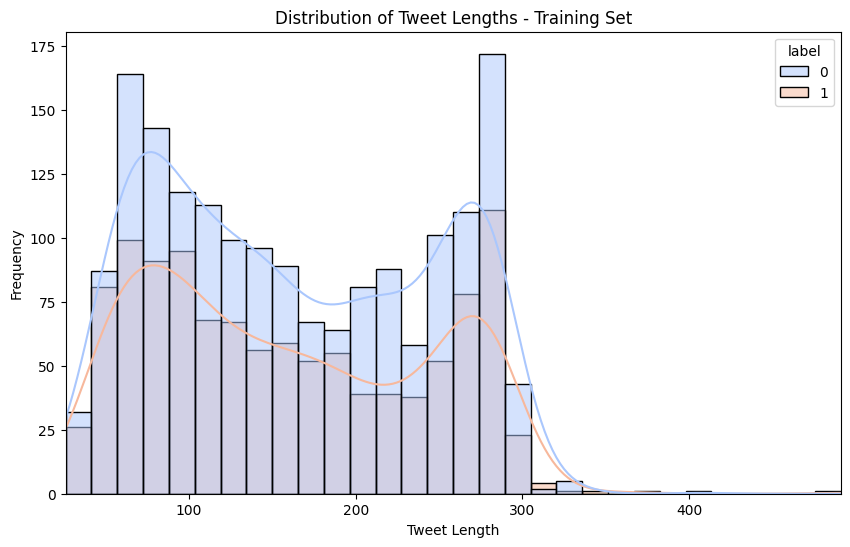

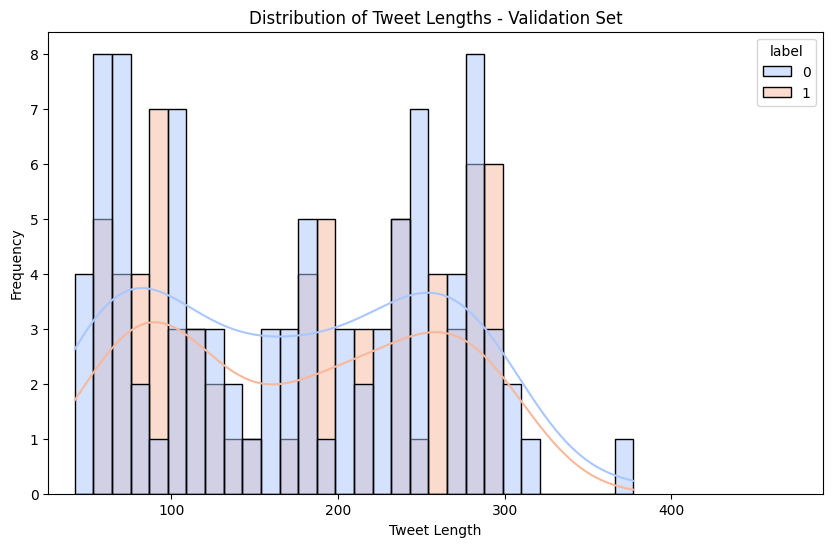

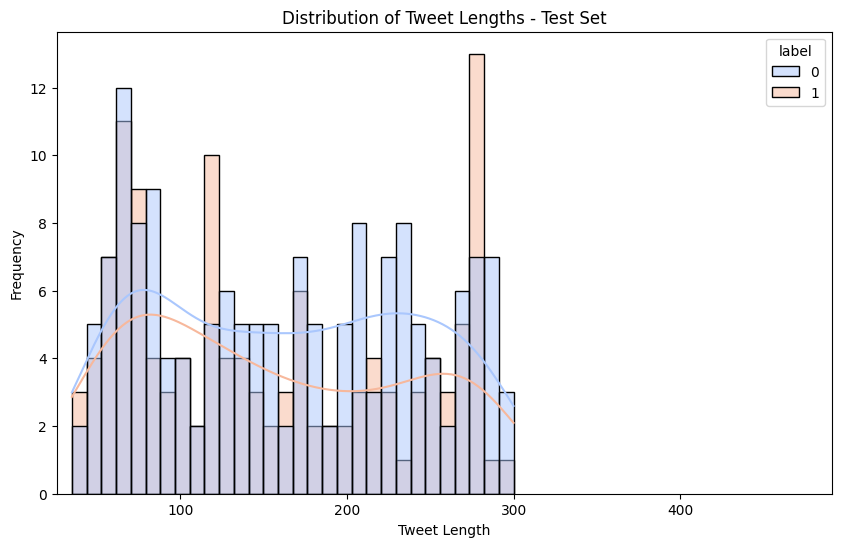

In [42]:
def plot_distr_tweet_len(data_list_or, labels):
    data_list = []
    for data_or in data_list_or:
        data = data_or.copy()
        data['tweet_length'] = data['tweet'].apply(len)
        data_list.append(data)

    # Determine global x and y axis limits
    all_lengths = pd.concat([data['tweet_length'] for data in data_list])
    x_min, x_max = all_lengths.min(), all_lengths.max()

    # Plot each dataset with consistent axes
    for i, data in enumerate(data_list):
        plt.figure(figsize=(10, 6))
        sns.histplot(data, x='tweet_length', hue='label', bins=30, kde=True, palette='coolwarm')
        plt.title(f'Distribution of Tweet Lengths - {labels[i]}')
        plt.xlabel('Tweet Length')
        plt.ylabel('Frequency')
        plt.xlim(x_min, x_max)
        plt.show()

plot_distr_tweet_len([data_train, data_val, data_test], labels=['Training Set', 'Validation Set', 'Test Set'])


Plot the most frequent words for each label

In [43]:
def analyze_top_words_by_label(data, text_column='tweet', label_column='label', n_top_words=20, exluded_words={}):
    # Ensure the input data has the required columns
    if text_column not in data.columns or label_column not in data.columns:
        raise ValueError(f"Dataframe must contain '{text_column}' and '{label_column}' columns.")

    # Define stop words
    stop_words = set(stopwords.words('english') + list(string.punctuation) + list(exluded_words))

    # Preprocessing function
    def preprocess_text(text):
        tokens = word_tokenize(text.lower())
        filtered_words = [word for word in tokens if word not in stop_words and word.isalnum()]
        return ' '.join(filtered_words)

    # Apply preprocessing to the text column
    data['cleaned_text'] = data[text_column].apply(preprocess_text)

    # Function to get top words
    def get_top_words(texts, n=20):
        all_words = ' '.join(texts).split()
        most_common = Counter(all_words).most_common(n)
        return pd.DataFrame(most_common, columns=['word', 'count'])

    # Find top words for each label and determine max count for consistent plotting
    max_count = 0
    label_top_words = {}
    for label in data[label_column].unique():
        subset = data[data[label_column] == label]
        top_words = get_top_words(subset['cleaned_text'], n=n_top_words)
        top_words = top_words[~top_words['word'].isin(exluded_words)]
        label_top_words[label] = top_words
        if not top_words.empty:
            max_count = max(max_count, top_words['count'].max())

    # Plot the results
    for label, top_words in label_top_words.items():
        if not top_words.empty:
            plt.figure(figsize=(12, 6))
            sns.barplot(data=top_words, x='count', y='word', palette='coolwarm')
            plt.title(f"Top Words for Label: {label}")
            plt.xlabel('Count')
            plt.ylabel('Word')
            plt.xlim(0, max_count + 5)  # Adding a small margin for better visuals
            plt.show()

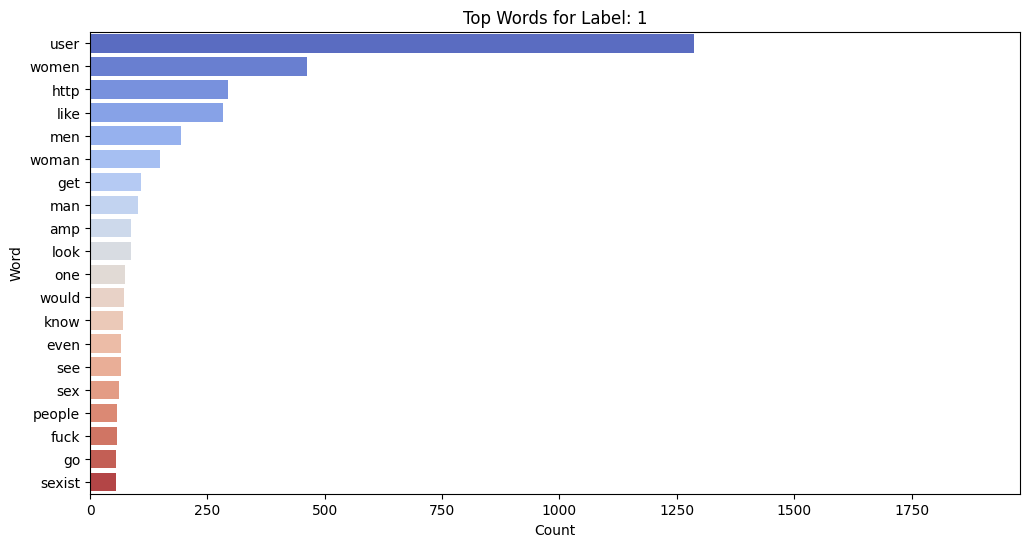

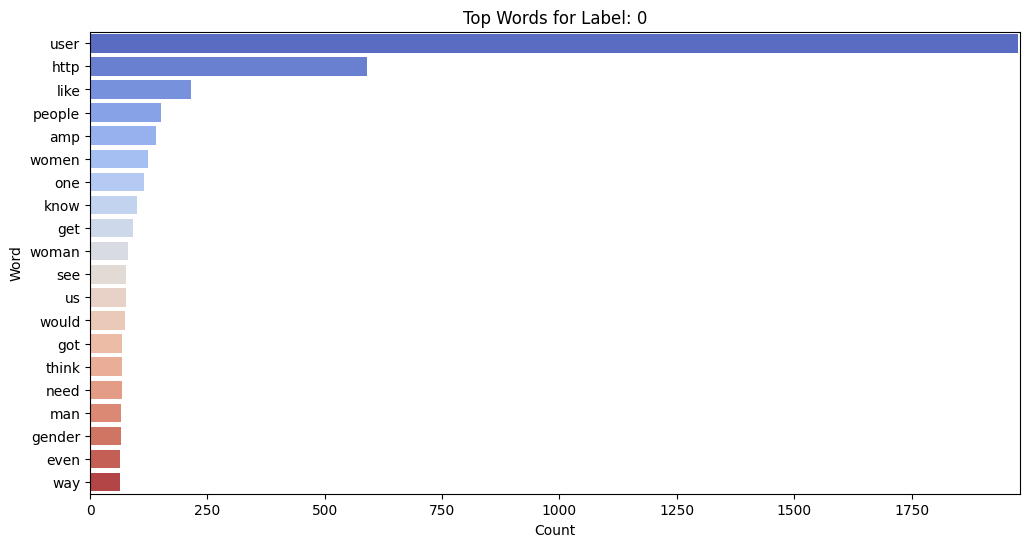

In [44]:
analyze_top_words_by_label(data_train, text_column='tweet', label_column='label', n_top_words=20)

Exclude some of the common words between the two labels to have a better understanding of the situation.

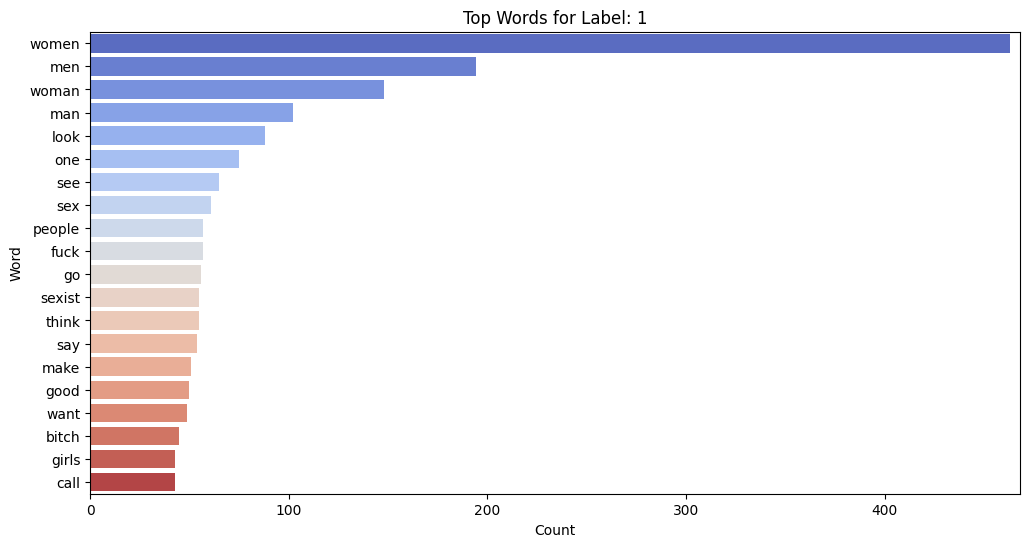

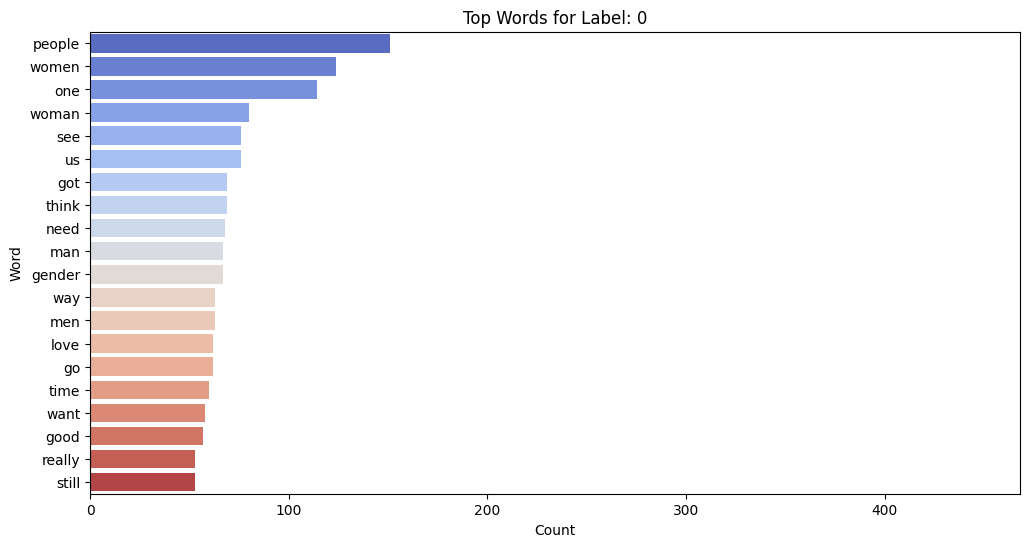

In [45]:
excluded_words = {'user', 'http', 'amp', 'like', 'get', 'know', 'would', 'even'}
analyze_top_words_by_label(data_train, text_column='tweet', label_column='label', n_top_words=20, exluded_words=excluded_words)

#### Confusion matrix and Precision-Recall curve


In [46]:
def plot_cf_and_PRcurve(y_test, y_prob):
    y_pred = np.argmax(y_prob, axis=-1)

    conf_matrix = confusion_matrix(y_test, y_pred)

    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    precision, recall, thresholds = precision_recall_curve(y_test, y_prob[:, 1])

    # Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="b", label="Precision-Recall Curve")
    plt.fill_between(recall, precision, color="skyblue", alpha=0.4)
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

Baseline model

DA METTERE A POSTO

In [47]:
plot_cf_and_PRcurve(baseline_labels, baseline_preds)

InvalidParameterError: The 'y_pred' parameter of confusion_matrix must be an array-like. Got 1 instead.

Model 1

DA METTERE A POSTO

In [ ]:
plot_cf_and_PRcurve(model_1_labels, model_1_preds)

Transformer model

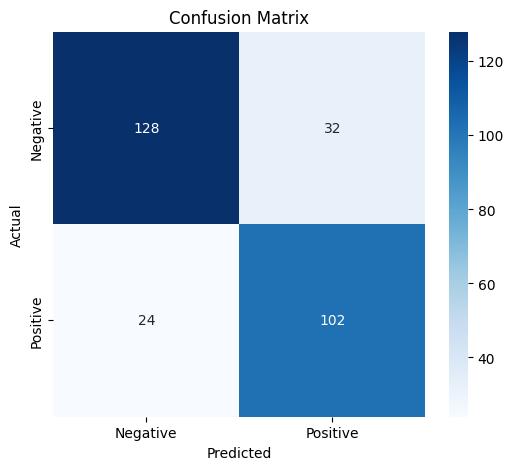

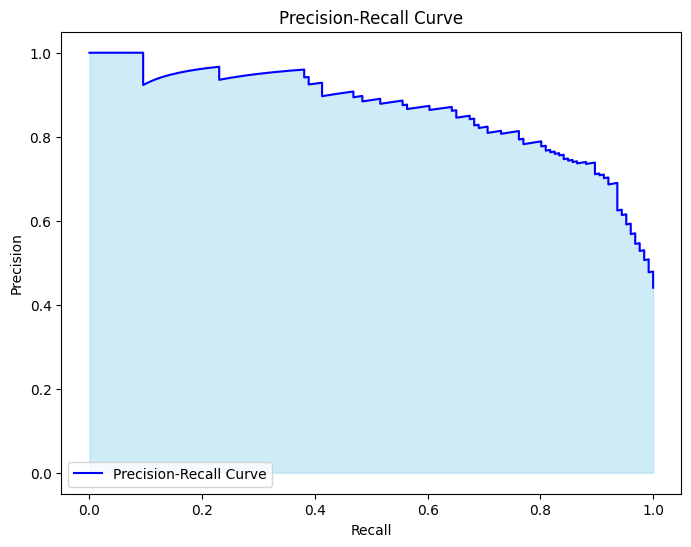


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       160
           1       0.76      0.81      0.78       126

    accuracy                           0.80       286
   macro avg       0.80      0.80      0.80       286
weighted avg       0.81      0.80      0.80       286



In [48]:
plot_cf_and_PRcurve(transformer_test_labels, transformer_test_predictions)

#### Specific misclassified samples

In [50]:
def analyze_errors(text, pred, label, tokenizer):
    # Check if pred and label are of the same length
    if len(pred) != len(label):
        raise ValueError("The length of prediction and label lists must be the same.")

    # Initialize a list to store the results of incorrect predictions
    incorrect_preds = []
    output_list = []

    pred = np.argmax(pred, axis=-1)
    # Iterate through each token in the prediction and label
    for i in range(len(pred)):
        # If the prediction is incorrect, we'll process this token
        if pred[i] != label[i]:
            incorrect_preds.append((text[i], i))
            output_list.append((text[i], pred[i]))

    print(f"Number of incorrect prediction: {len(incorrect_preds)}")
    print()
    print("First dot reprsent label, second represent prediction, red means sexist")
    # If there are incorrect predictions, print them and color OOV tokens
    for err, idx in incorrect_preds:
        if label[idx] == 1:
            print("🔴", end=" ")
        else:
            print("🟢", end=" ")
        if pred[idx] == 1:
            print("🔴", end=" ")
        else:
            print("🟢", end=" ")
        print(err)

    return output_list

incpreds = analyze_errors(data_test['tweet'], transformer_test_labels, transformer_test_labels, tokenizer)

TypeError: object of type 'numpy.int64' has no len()

In [ ]:
errors_df = pd.DataFrame(incpreds, columns=["tweet", "label"])
analyze_top_words_by_label(errors_df, text_column='tweet', label_column='label', n_top_words=20, exluded_words=excluded_words)

Top words for baseline model

In [ ]:
analyze_top_words_by_label(baseline_error_df, text_column='tweet', label_column='label', n_top_words=20)

Top words for model 1

In [ ]:
analyze_top_words_by_label(model_1_error_df, text_column='tweet', label_column='label', n_top_words=20)

In [51]:
def highlight_oov_tokens(df, vocabulary, tweet_column="tweet", label_column="label", oov_column="oov_token_count"):
    # Extract vocabulary keys
    vocab_keys = set(vocabulary.keys())

    def highlight_tokens(tweet):
        """Highlight OOV tokens in red within the tweet."""
        tokens = tweet.split()  # Assuming tweets are space-separated strings
        highlighted = [
            f"\033[91m{token}\033[0m" if token not in vocab_keys else token
            for token in tokens
        ]
        return " ".join(highlighted)

    print(f"\n{'Label':<6}{'Tweet (OOV tokens highlighted in red)':<60}")
    print("-" * 70)

    for _, row in df.iterrows():
        label = row[label_column]
        tweet = row[tweet_column]
        label_emoji = "🔴" if label == 1 else "🟢"
        highlighted_tweet = highlight_tokens(tweet)
        print(f"{label_emoji:<6}{highlighted_tweet}")

highlight_oov_tokens(baseline_error_df, vocab, tweet_column="tweet", label_column="label", oov_column="oov_token_count")


Label Tweet (OOV tokens highlighted in red)                       
----------------------------------------------------------------------
🔴     fuck cunt tried vote multiple time
🔴     suika get gangbanged death
🔴     maybe something involving getting gangbanged
🟢     sex gender harassment inferring
🔴     kabul islamic emirate afghanistan announced end coeducation country citing gender harassmentfemale student attend university monday wednesday saturday tuesday thursday sunday fixed male
🔴     violent antifeminism farright movement see principally vessel breeding new white generation express fixation areturn traditional gender rolesworth every minute read take 5 min sun
🔴     ah look gender role back dont believe lie
🟢     isa hot girl summer pop yall shit
🟢     baby called mommy sha first time today twice yall dont understand hype made baby girl autism getting talk without prompted challenge shes come far
🟢     reach point blonks audacity talk yoongis rap yall see stan yall ok girl c

In [52]:
highlight_oov_tokens(model_1_error_df, vocab, tweet_column="tweet", label_column="label", oov_column="oov_token_count")


Label Tweet (OOV tokens highlighted in red)                       
----------------------------------------------------------------------
🔴     like outfit except dress frigid bitch try look constipated new
🔴     fuck cunt tried vote multiple time
🔴     u got ta say shit like ill fuck cunt dumb cant remember anything name stupid slut
🔴     mmm fuck cunt hungry dick isnt shame lie want wanting body never canhe say ear start kissing neck making sure leave plenty love mark pale skin
🔴     suika get gangbanged death
🔴     maybe something involving getting gangbanged
🔴     kabul islamic emirate afghanistan announced end coeducation country citing gender harassmentfemale student attend university monday wednesday saturday tuesday thursday sunday fixed male
🔴     violent antifeminism farright movement see principally vessel breeding new white generation express fixation areturn traditional gender rolesworth every minute read take 5 min sun
🔴     ah look gender role back dont believe lie
🔴   

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End